In [11]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

2.5.1+cu121
Populating the interactive namespace from numpy and matplotlib


In [16]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [22]:
import yfinance as yf
import datetime

# 날짜 설정
start = datetime.datetime(2000, 12, 1)  # 시작 날짜
end = datetime.date.today()             # 종료 날짜 (오늘)

# 주식 데이터 가져오기 ('028050.KS'는 삼성엔지니어링의 한국 거래소 티커)
google = yf.download('TSLA', start=start, end=end)

# 결과 출력
print(google.head())  # 첫 5개 행 출력


[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          TSLA      TSLA      TSLA      TSLA      TSLA       TSLA
Date                                                                   
2010-06-29  1.592667  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.074000  1.333333  1.055333  1.333333  103003500


In [23]:
google.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


<Axes: xlabel='Date'>

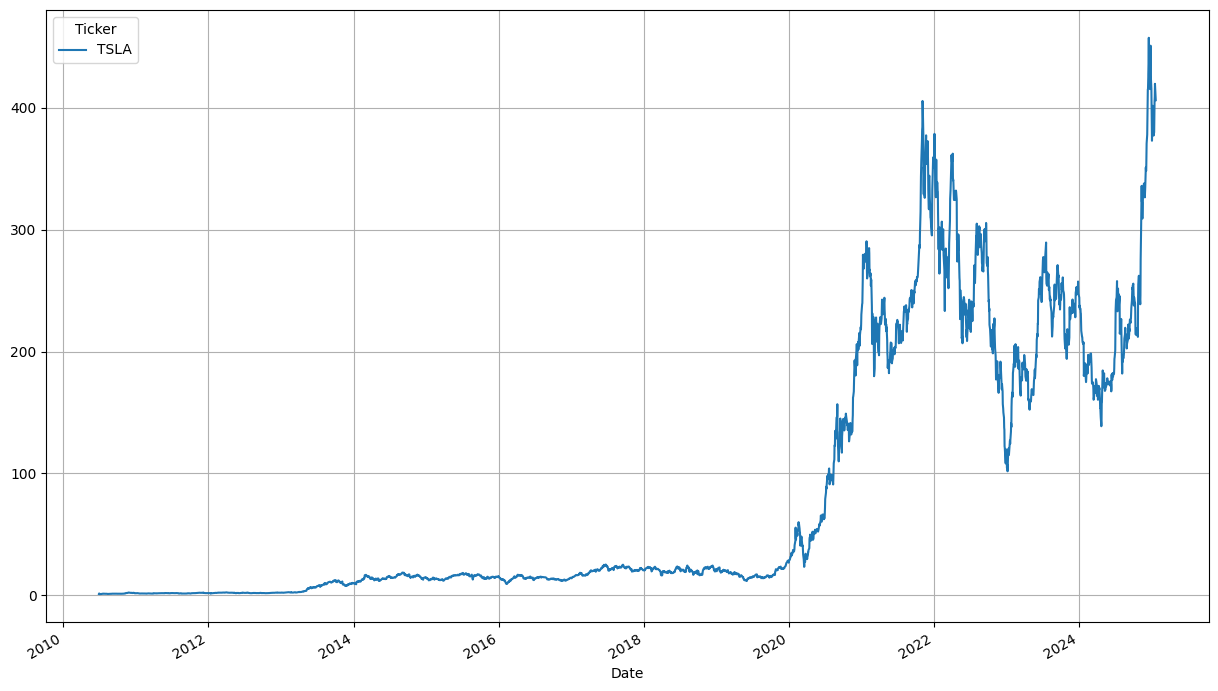

In [25]:
google.Low.plot(grid=True)

In [24]:
google.tail()
print(google.isna().sum())

Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64


In [51]:
google.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2025-01-14,396.359985,396.359985,422.640015,394.540009,414.339996,84565000
2025-01-15,428.220001,428.220001,429.799988,405.660004,409.899994,81375500
2025-01-16,413.820007,413.820007,424.000000,409.130005,423.489990,68335200
2025-01-17,426.500000,426.500000,439.739990,419.750000,421.500000,94991400
2025-01-21,424.070007,424.070007,433.200012,406.309998,432.640015,86980300


In [26]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = yf.download(self.symbol, self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [27]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [28]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [29]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [30]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad(): # 학습불가, 파라미터를 업그레이드 하지 않겠다
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [31]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [32]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [45]:
mkdir result

In [33]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [57]:
df

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,device,symbol,...,y_frames,input_dim,hid_dim,n_layers,l2,dropout,use_bn,optim,lr,epoch
0,"[0.01099290419369936, 0.007860523648560047]","[0.011002455838024616, 0.010588786165629114]","[16.274389266967773, 14.949283599853516]","[18.311351776123047, 17.916269302368164]",14.949284,17.916269,18.078662,exp1_lr,cpu,TSLA,...,5,6,50,3,0.00001,0.0,True,RMSprop,0.00010,2
1,"[0.061694882810115814, 0.059615608304739]","[0.009793246297964029, 0.00902889555852328]","[12.264530658721924, 16.763437747955322]","[11.239639963422503, 10.11326231275286]",16.763438,10.113262,9.917618,exp1_lr,cpu,TSLA,...,5,6,50,2,0.00001,0.0,True,RMSprop,0.00100,2
2,"[0.032854076474905014, 0.020178225822746754]","[0.023141282477549145, 0.022441106449280466]","[10.35166883468628, 7.5604777336120605]","[9.671042578560966, 9.420115743364606]",7.560478,9.420116,9.229358,exp1_lr,cpu,TSLA,...,5,6,50,2,0.00001,0.0,True,RMSprop,0.00010,2
3,"[0.013335827738046646, 0.012294303625822067]","[0.010144587473145552, 0.010266454225139958]","[3.860807418823242, 3.5776530504226685]","[1.910611867904663, 1.9126678364617484]",3.577653,1.912668,1.758886,exp1_lr,cpu,TSLA,...,5,6,50,3,0.00001,0.0,True,RMSprop,0.00001,2
4,"[0.046786434948444366, 0.01895204931497574]","[0.009162557045263904, 0.008054350835404225]","[19.83588457107544, 9.508191585540771]","[2.6791556222098216, 2.7075985159192766]",9.508192,2.707599,2.474659,exp1_lr,cpu,TSLA,...,5,6,50,1,0.00001,0.0,True,RMSprop,0.00100,2
5,"[0.030169136822223663, 0.027868804521858692]","[0.016630781681409905, 0.0164683855005673]","[7.824258327484131, 7.5489747524261475]","[3.968777758734567, 3.8309075832366943]",7.548975,3.830908,3.607168,exp1_lr,cpu,TSLA,...,5,6,50,2,0.00001,0.0,True,RMSprop,0.00001,2
6,"[0.07935178652405739, 0.05752047151327133]","[0.008747777568974666, 0.008426771499216557]","[7.136263132095337, 6.182397842407227]","[2.0261196749550954, 1.971472178186689]",6.182398,1.971472,1.789246,exp1_lr,cpu,TSLA,...,5,6,50,1,0.00001,0.0,True,RMSprop,0.00010,2
7,"[0.07604160904884338, 0.07330834493041039]","[0.019595134471143996, 0.01952340773173741]","[20.114550590515137, 19.359219551086426]","[17.361502511160715, 17.230546678815568]",19.359220,17.230547,17.062726,exp1_lr,cpu,TSLA,...,5,6,50,1,0.00001,0.0,True,RMSprop,0.00001,2
8,"[0.043393795378506184, 0.019835807383060455]","[0.010170627252331801, 0.008788313117942639]","[9.710736513137817, 11.62901258468628]","[4.088936907904489, 3.599445308957781]",11.629013,3.599445,3.372004,exp1_lr,cpu,TSLA,...,5,6,50,3,0.00001,0.0,True,RMSprop,0.00100,2


In [34]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [42]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = 'TSLA'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2

In [43]:
trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64
Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64
Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64


In [50]:
import warnings

# FutureWarning 무시 설정
warnings.simplefilter(action='ignore', category=FutureWarning)

# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001] 
list_var2 = [1, 2, 3]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)


Namespace(exp_name='exp1_lr', device='cpu', symbol='TSLA', batch_size=128, x_frames=5, y_frames=5, input_dim=6, hid_dim=50, n_layers=1, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=2)
Epoch 0, Acc(train/val): 19.84/2.68, Loss(train/val) 0.04679/0.00916. Took 4.03 sec
Epoch 1, Acc(train/val): 9.51/2.71, Loss(train/val) 0.01895/0.00805. Took 4.04 sec
Namespace(exp_name='exp1_lr', device='cpu', symbol='TSLA', batch_size=128, x_frames=5, y_frames=5, input_dim=6, hid_dim=50, n_layers=2, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=2)
Epoch 0, Acc(train/val): 12.26/11.24, Loss(train/val) 0.06169/0.00979. Took 4.03 sec
Epoch 1, Acc(train/val): 16.76/10.11, Loss(train/val) 0.05962/0.00903. Took 3.99 sec
Namespace(exp_name='exp1_lr', device='cpu', symbol='TSLA', batch_size=128, x_frames=5, y_frames=5, input_dim=6, hid_dim=50, n_layers=3, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=2)
Epoch 0, Acc(train/val): 9.71/4.09, Los

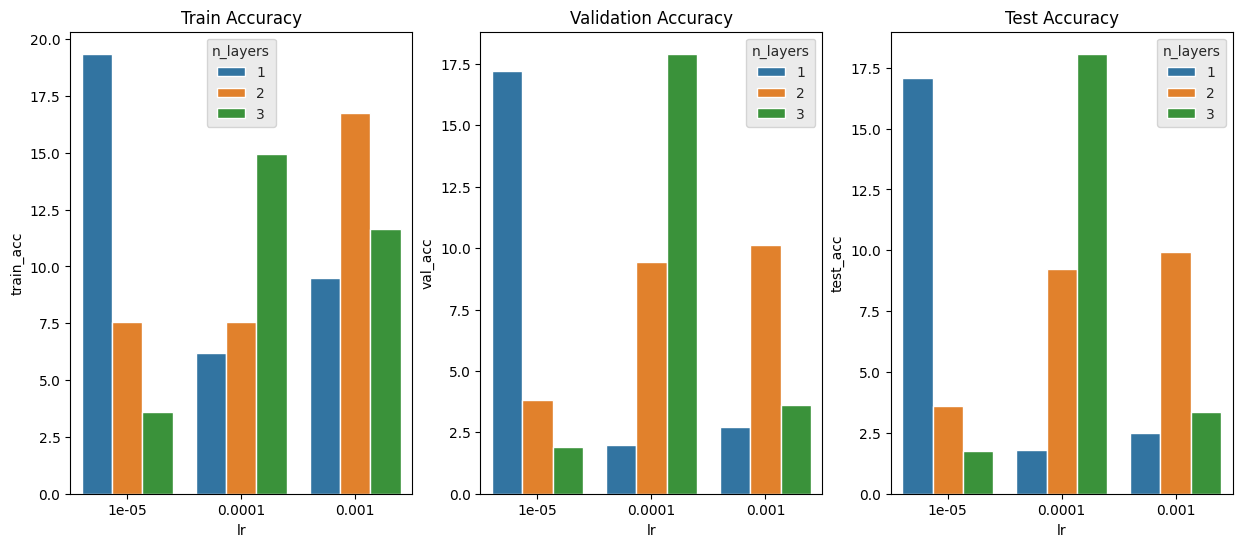

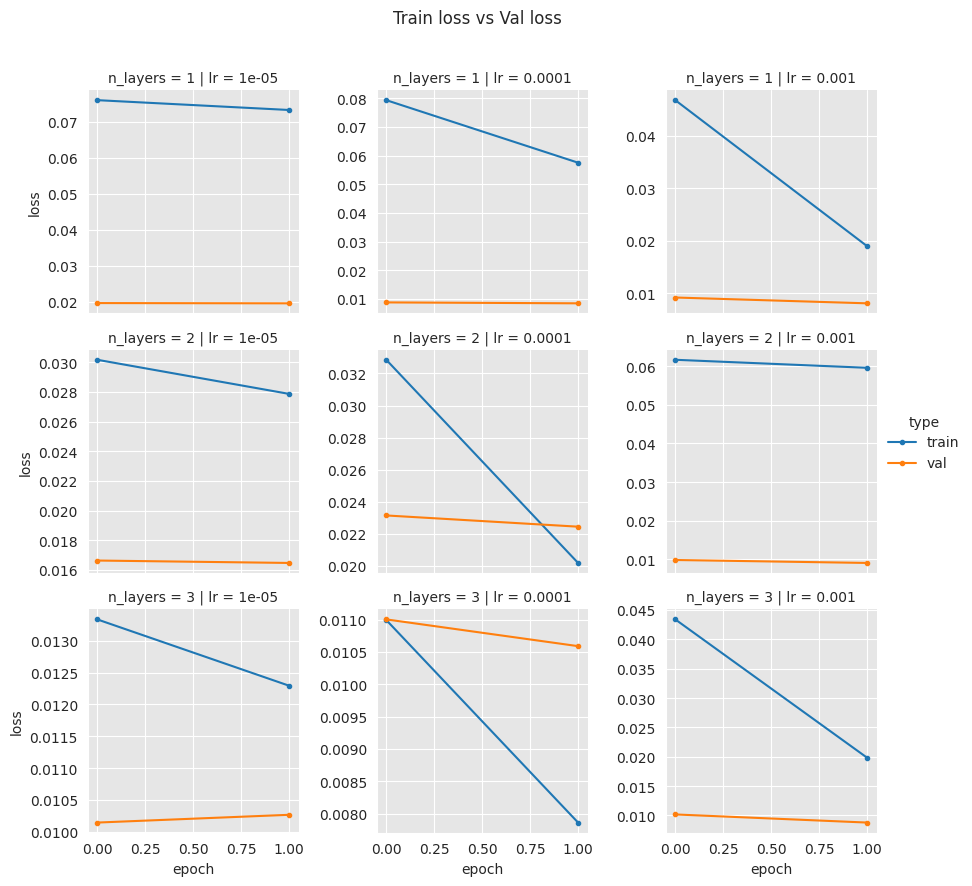

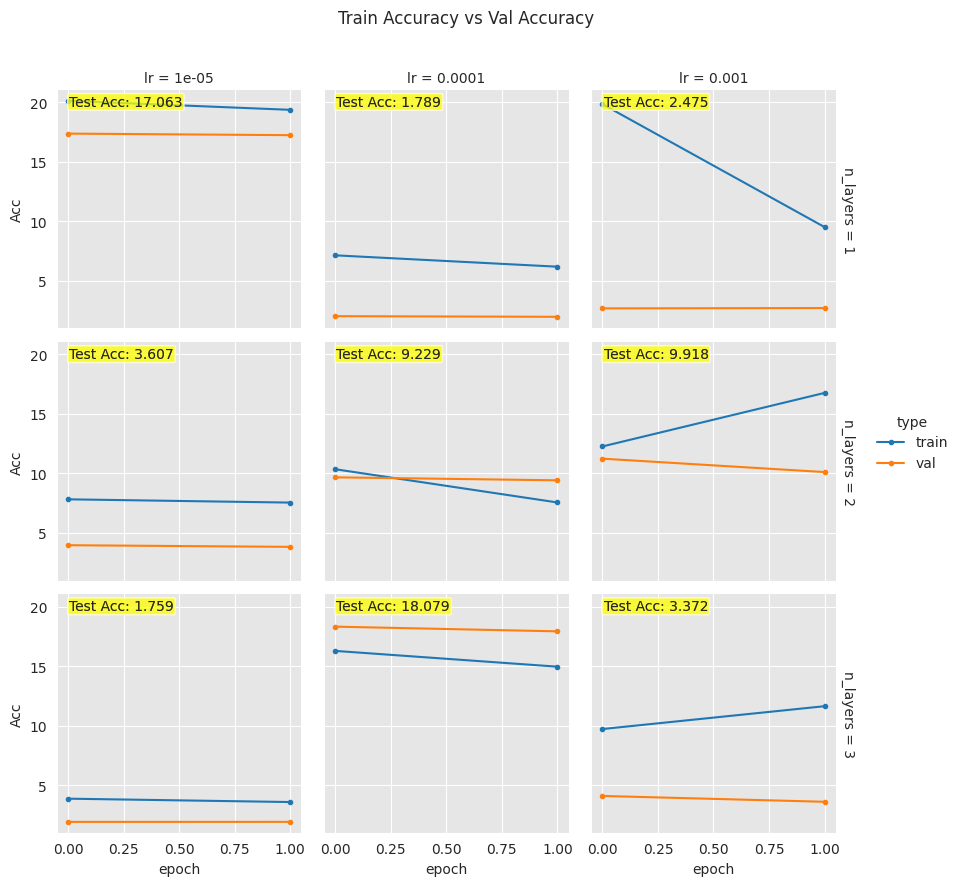

In [52]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

In [53]:
google

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...,...
2025-01-14,396.359985,396.359985,422.640015,394.540009,414.339996,84565000
2025-01-15,428.220001,428.220001,429.799988,405.660004,409.899994,81375500


In [55]:
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, data, time_step=60):
        """
        Args:
            data (numpy array): 정규화된 주식 데이터 (예: Close 값)
            time_step (int): LSTM에 입력할 시간 단계 (default=60)
        """
        self.data = data
        self.time_step = time_step
        self.X, self.y = self.create_dataset(data, time_step)

    def create_dataset(self, data, time_step):
        """
        시계열 데이터를 LSTM 입력 형식으로 변환
        """
        X, y = [], []
        for i in range(time_step, len(data)):
            X.append(data[i-time_step:i, 0])  # time_step 길이의 시계열 데이터
            y.append(data[i, 0])  # 다음 시점의 데이터
        return np.array(X), np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)


In [87]:
# google 데이터프레임을 'google_stock_data.csv'라는 파일로 저장
google.to_csv("google_stock_data.csv", encoding="utf-8-sig")

print("CSV 파일이 생성되었습니다: google_stock_data.csv")


CSV 파일이 생성되었습니다: google_stock_data.csv


In [88]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드 (CSV 파일)
df = pd.read_csv('/kaggle/working/google_stock_data.csv')

In [89]:
df

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-06-29,1.5926669836044312,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
3,2010-06-30,1.5886670351028442,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
4,2010-07-01,1.4639999866485596,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000
...,...,...,...,...,...,...,...
3661,2025-01-14,396.3599853515625,396.3599853515625,422.6400146484375,394.5400085449219,414.3399963378906,84565000
3662,2025-01-15,428.2200012207031,428.2200012207031,429.79998779296875,405.6600036621094,409.8999938964844,81375500
3663,2025-01-16,413.82000732421875,413.82000732421875,424.0,409.1300048828125,423.489990234375,68335200
3664,2025-01-17,426.5,426.5,439.739990234375,419.75,421.5,94991400


In [90]:
df2 = df.drop([0, 1])

In [91]:
df2

,Price,Adj Close,Close,High,Low,Open,Volume
2,2010-06-29,1.5926669836044312,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
3,2010-06-30,1.5886670351028442,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
4,2010-07-01,1.4639999866485596,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000
5,2010-07-02,1.2799999713897705,1.2799999713897705,1.5399999618530273,1.24733304977417,1.5333329439163208,77097000
6,2010-07-06,1.0740000009536743,1.0740000009536743,1.3333330154418945,1.0553330183029175,1.3333330154418945,103003500
...,...,...,...,...,...,...,...
3661,2025-01-14,396.3599853515625,396.3599853515625,422.6400146484375,394.5400085449219,414.3399963378906,84565000
3662,2025-01-15,428.2200012207031,428.2200012207031,429.79998779296875,405.6600036621094,409.8999938964844,81375500
3663,2025-01-16,413.82000732421875,413.82000732421875,424.0,409.1300048828125,423.489990234375,68335200
3664,2025-01-17,426.5,426.5,439.739990234375,419.75,421.5,94991400


In [96]:
df2['Date'] = pd.to_datetime(df2['Price'])  # 'Date' 열을 날짜 형식으로 변환
df2.set_index('Date', inplace=True)  # 'Date'를 인덱스로 설정

In [97]:
df2

,Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-06-29,2010-06-29,1.5926669836044312,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
2010-06-30,2010-06-30,1.5886670351028442,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
2010-07-01,2010-07-01,1.4639999866485596,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000
2010-07-02,2010-07-02,1.2799999713897705,1.2799999713897705,1.5399999618530273,1.24733304977417,1.5333329439163208,77097000
2010-07-06,2010-07-06,1.0740000009536743,1.0740000009536743,1.3333330154418945,1.0553330183029175,1.3333330154418945,103003500
...,...,...,...,...,...,...,...
2025-01-14,2025-01-14,396.3599853515625,396.3599853515625,422.6400146484375,394.5400085449219,414.3399963378906,84565000
2025-01-15,2025-01-15,428.2200012207031,428.2200012207031,429.79998779296875,405.6600036621094,409.8999938964844,81375500
2025-01-16,2025-01-16,413.82000732421875,413.82000732421875,424.0,409.1300048828125,423.489990234375,68335200


In [98]:
# 'Close' 열 선택 및 정규화
from sklearn.preprocessing import MinMaxScaler

In [99]:
data = df2[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [100]:
# 정규화된 데이터 출력 (일부 확인)
print(scaled_data[:5])  # 처음 5개의 정규화된 값 출력

[[1.12641280e-03]
 [1.11805880e-03]
 [8.57688465e-04]
 [4.73399704e-04]
 [4.31634707e-05]]


In [101]:
scaled_data

array([[1.12641280e-03],
       [1.11805880e-03],
       [8.57688465e-04],
       ...,
       [8.62073808e-01],
       [8.88556299e-01],
       [8.83481197e-01]])

In [102]:
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:]

In [103]:
# StockDataset으로 학습 및 테스트 데이터 생성
train_dataset = StockDataset(train_data, time_step=60)
test_dataset = StockDataset(test_data, time_step=60)

# DataLoader 생성 (옵션)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [106]:
train_data

array([[0.00112641],
       [0.00111806],
       [0.00085769],
       ...,
       [0.60748254],
       [0.63997298],
       [0.64064133]])

In [107]:
test_data

array([[0.80318431],
       [0.76987931],
       [0.77473165],
       [0.75100603],
       [0.78934438],
       [0.79475365],
       [0.76011197],
       [0.75287173],
       [0.70439707],
       [0.70024787],
       [0.73000241],
       [0.74198358],
       [0.6966208 ],
       [0.70583121],
       [0.67059078],
       [0.665091  ],
       [0.67726013],
       [0.64309882],
       [0.64703221],
       [0.62431605],
       [0.65118141],
       [0.70015041],
       [0.74061904],
       [0.75937402],
       [0.75556594],
       [0.75397865],
       [0.74294428],
       [0.73350417],
       [0.83305721],
       [0.79811615],
       [0.75532228],
       [0.73901785],
       [0.71274422],
       [0.73443702],
       [0.73880898],
       [0.76792303],
       [0.71594661],
       [0.72851256],
       [0.71521561],
       [0.69094695],
       [0.69137858],
       [0.65491989],
       [0.64524305],
       [0.63716742],
       [0.65040172],
       [0.57499898],
       [0.587008  ],
       [0.649

In [108]:
train_loader

In [109]:
test_loader

In [110]:
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [112]:
model = StockLSTM().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [111]:
# 학습 루프
for epoch in range(10):  # 에포크 10회 반복
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        predictions = model(X_batch.unsqueeze(-1))  # (batch_size, time_step, input_size=1)
        loss = criterion(predictions, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx